# ENSO Recharge Oscillator Practical: Simulations and Forecasting

This notebook serves as the Recharge Oscillator (RO) Practical for the [ENSO Winter School 2025](https://sites.google.com/hawaii.edu/enso-winter-school-2025/). It covers both theoretical and computational aspects of the RO framework, demonstrating its applications in ENSO simulations and forecasting.

**Instructors**
- **Sen Zhao** (<zhaos@hawaii.edu>)
- **Soong-Ki Kim** (<sskk503@yonsei.ac.kr>)
- **Jérôme Vialard** (<jerome.vialard@ird.fr>)

---

### Overview

In this notebook, we will demonstrate how to use the `XRO` framework for **Recharge-Oscillator (RO) model** fitting, simulations, and reforecasting.

***Extended Nonlinear Recharge Oscillator (XRO) framework***

The `XRO` framework was developed to investigate the role of climate mode interactions in ENSO dynamics and predictability ([Zhao et al. 2024](https://doi.org/10.1038/s41586-024-07534-6)). When other climate modes are not considered, it simplifies to the Recharge Oscillator (RO), making it well-suited for use in this practical context. We have designed `XRO` to be user-friendly, aiming to be a valuable tool not only for research but also for operational forecasting and as an educational resource in the classroom.

> Check out the updated version of XRO at https://github.com/senclimate/XRO


***Community Recharge Oscillator (CRO) model framework***

The `CRO` code package is an easy-to-use Python/MATLAB software for solving and fitting the ENSO RO model. The `CRO` code is currently under development and is planned for release in 2025. The distributed version for the ENSO Winter School 2025 is a light Python version that includes only the essential features. While we introduce the `CRO` framework in this practical, some of its functionalities are unavailable. Therefore, for consistency, we will primarily use the `XRO` framework.

For those interested in the `CRO` code, please refer to the Jupyter notebook:  
📂 *CRO_test/RO_Practical_with_CRO_Framework.ipynb*

Special thanks to **Bastien Pagli** for providing the original `CRO` code in Python.

---

### Run it at Google Colab
You can easily run this notebook on [Google Colab](https://colab.research.google.com/). 

Simply download [this notebook](RO_parctical_with_XRO_framework.ipynb) and upload it to Google Colab. 

Once uploaded, you can execute the notebook directly— all required data and Python libraries will be downloaded and installed automatically.


Load basic python libraries
Include libraries for both computing and visualization

In [1]:
## if you run in google colab, you need to uncomment the following and download the data and XRO source code to run this notebook

# run_google_colab = True
run_google_colab = False


In [2]:
import importlib.util
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

# Function to check and install a package if not found
def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")

# List of required packages
required_packages = [
    "matplotlib", "numpy", "xarray", "nc-time-axis", "cftime", "climpred", "dateutil", "seaborn",
]

if run_google_colab:
    # Install missing packages if needed
    for pkg in required_packages:
        install_if_missing(pkg)

# Importing libraries after ensuring they are installed
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from climpred import HindcastEnsemble
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator


In [3]:
if run_google_colab:
    # Download necessary files if running in Google Colab
    !wget -cq https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc
    !wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO.py
    !wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO_utils.py

# def setup_module_path():
# module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/XRO-main'
# sys.path.append(module_path)

# Import necessary modules after ensuring files are available
from XRO import XRO, xcorr, SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm
# from XRO_utils import SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm

print("All required libraries are installed and imported successfully!")

All required libraries are installed and imported successfully!


## 1. Observed ENSO properties related to RO

Two indices are used to describe the oscillatory behaviour of ENSO. 
 - **$T$**: Sea surface temperature (SST) anomalies averaged over the Niño3.4 region 170°–120° W, 5° S–5° N
 - **$h$** Thermocline depth anomalies averaged over the equatorial Pacific 120° E–80° W, 5° S–5° N, that is, the WWV index (with a constant factor of the area it covers).


In [4]:
# prepare NPP file
npp_file = '/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_photoC_TOT_zint_100m_x1_210_x2_270_y1_-20_y2_10.nc'
npp_ds = xr.open_dataset(npp_file).sel(time=slice('1979-01', '2024-12'))
print(npp_ds)

In [6]:
# load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;
if run_google_colab:
    obs_file = './XRO_indices_oras5.nc'
else:
    # obs_file = '../data/XRO_indices_oras5.nc'
    obs_file = '/mnt/lustre/proj/kimyy/Dropbox/source/python/all/Modules/RO_practical-main/data/XRO_indices_oras5.nc'

# obs_ds = xr.open_dataset(obs_file).sel(time=slice('1979-01', '2024-12'))
obs_ds = xr.open_dataset(obs_file).sel(time=slice('1998-01', '2024-12'))

obs_RO_ds = obs_ds[['Nino34', 'WWV']]
print(obs_RO_ds)

<xarray.Dataset> Size: 6kB
Dimensions:  (time: 324)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1998-01-01 1998-02-01 ... 2024-12-01
    month    (time) int32 1kB ...
Data variables:
    Nino34   (time) float32 1kB ...
    WWV      (time) float32 1kB ...


In [7]:
# obs + npp
npp = npp_ds['obs_photoC_TOT_zint_100m'].rename('NPP')
npp_on_obs_time = npp.reindex(time=obs_RO_ds.time)
obs_with_npp = obs_RO_ds.copy()
obs_with_npp['NPP'] = npp_on_obs_time


### 1.1 ENSO time series

Text(0.5, 1.0, 'ORAS5 Nino3.4 and WWV indices')

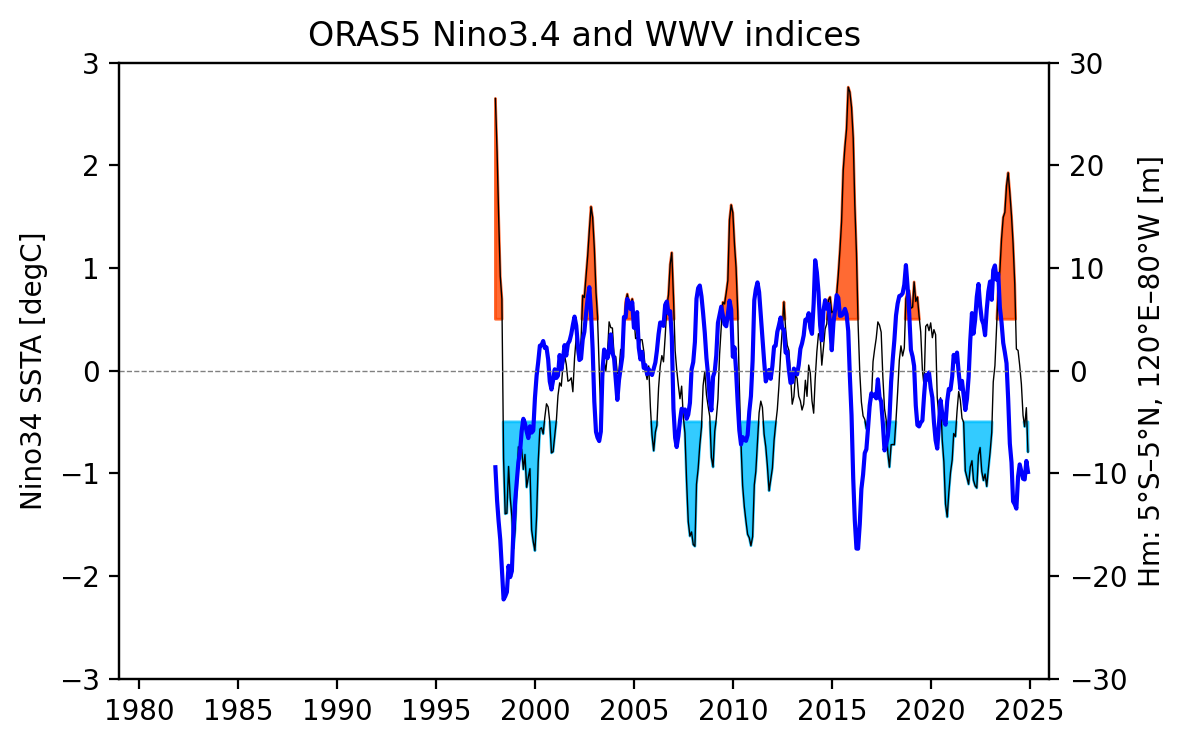

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

plot_above_below_shading(obs_RO_ds['Nino34'], xtime=obs_RO_ds.time, 
                         c='black', lw=0.5, 
                         above=0.5, above_c='orangered',
                         below=-0.5, below_c='deepskyblue', 
                         ax=ax)
# obs_RO_ds['Nino34'].plot(ax=ax, c='black', )
ax.set_ylim([-3, 3])
ax.set_ylabel('Nino34 SSTA [degC]')

axR = ax.twinx()
obs_RO_ds['WWV'].plot(ax=axR, c='blue', lw=1.5)
axR.set_ylim([-30, 30])
axR.axhline(0, ls='--', c='gray', lw=0.5)

ax.set_xlim([datetime.datetime(1979, 1, 1), datetime.datetime(2026, 1, 1)])
ax.set_title('ORAS5 Nino3.4 and WWV indices')

### 1.2 Observed ENSO seasonal synchronization

It can be represented as ENSO SSTA's seasonal variance (or standard deviation)

In [9]:
stddevAC_obs_ds = obs_RO_ds.groupby('time.month').std('time')
print(stddevAC_obs_ds)

<xarray.Dataset> Size: 192B
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Nino34   (month) float32 48B 1.203 0.9913 0.7584 ... 0.9704 1.151 1.185
    WWV      (month) float32 48B 4.332 5.453 6.76 7.377 ... 6.533 6.036 5.018


Text(0.5, 1.0, 'ENSO seasonal synchronization')

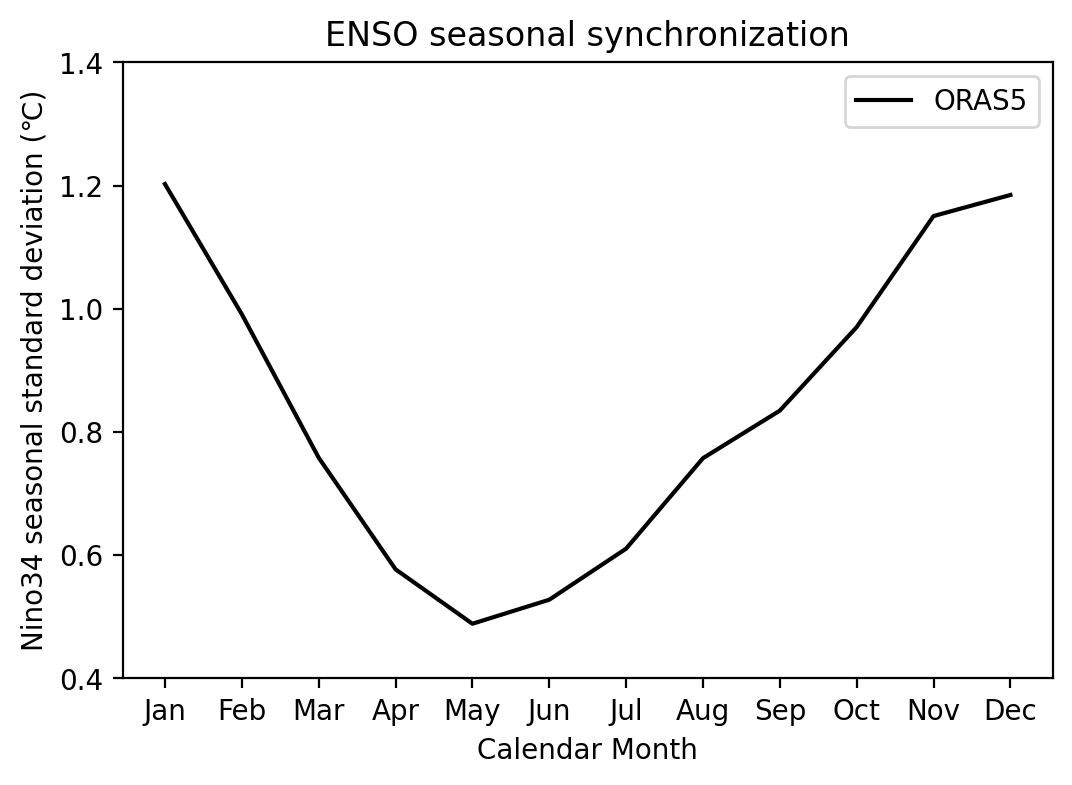

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plt.xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Nino34 seasonal standard deviation (℃)')
plt.xlabel('Calendar Month')
plt.legend()
plt.ylim([0.4, 1.4])
plt.title('ENSO seasonal synchronization')

### 1.3 Observed ENSO asymmetry and skewness

- Check the function compute_skew in XRO_utils.py
- Compute the ENSO's skewness 

In [11]:
skew_obs_ds = obs_RO_ds.skew('time')
print(skew_obs_ds)

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    Nino34   float32 4B 0.5493
    WWV      float32 4B -0.9941


### 1.4 ENSO SST-WWV relationships
Leadlag cross-correlations (See details `xcorr` in XRO_utils.py)

In [12]:
ccr_obs_ds = xcorr(obs_RO_ds, obs_RO_ds['Nino34'], maxlags=36)
print(ccr_obs_ds)

<xarray.Dataset> Size: 1kB
Dimensions:  (lag: 73)
Coordinates:
  * lag      (lag) int32 292B -36 -35 -34 -33 -32 -31 -30 ... 31 32 33 34 35 36
Data variables:
    Nino34   (lag) float64 584B -0.009744 -0.011 -0.01977 ... -0.011 -0.009744
    WWV      (lag) float64 584B -0.06426 -0.07416 -0.08466 ... 0.09694 0.07778


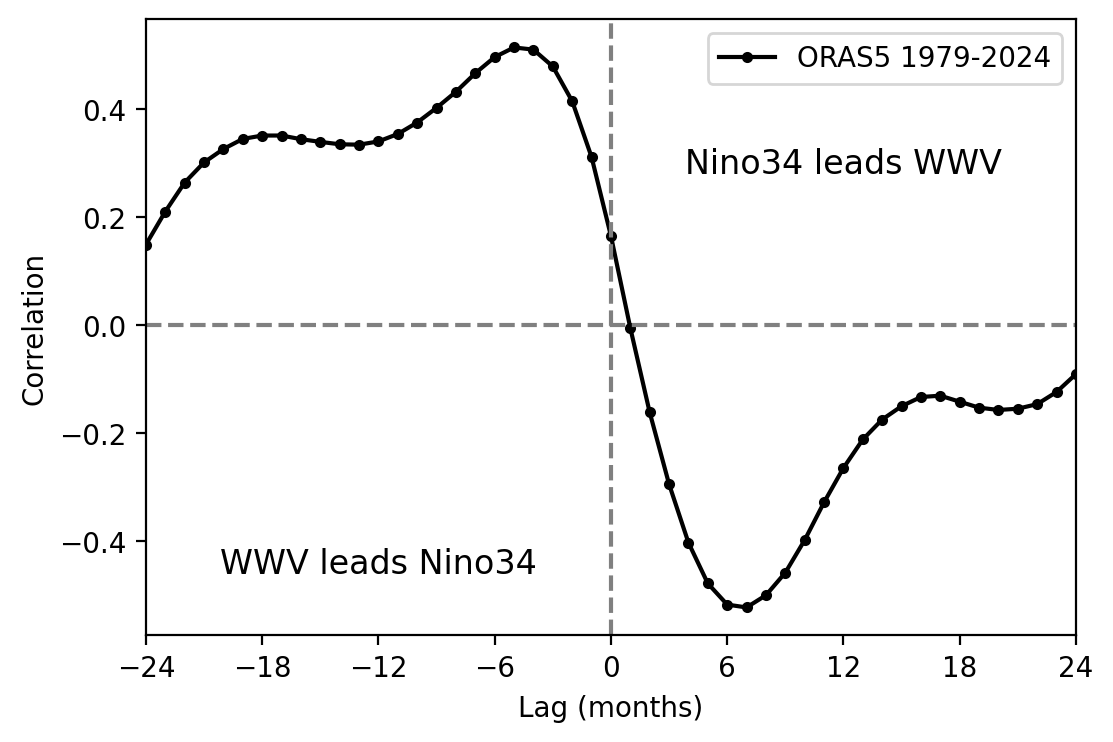

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sel_var = 'WWV'
ax.plot(ccr_obs_ds.lag, ccr_obs_ds[sel_var], c='black', marker='.', label='ORAS5 1979-2024')

ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (months)')
ax.set_xticks(np.arange(-36, 37, step=6))
ax.text(0.25, 0.1,'WWV leads Nino34', ha='center', transform=ax.transAxes, fontsize='large')
ax.text(0.75, 0.75,'Nino34 leads WWV', ha='center', transform=ax.transAxes, fontsize='large')
ax.set_xlim([-24, 24])
ax.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--', c='gray')
ax.legend()

#### Decadal shift in ENSO SST-WWV relationships
- McPhaden, M. J. (2012). A 21st century shift in the relationship between ENSO SST and warm water volume anomalies. Geophysical Research Letters, 39(9). https://doi.org/10.1029/2012GL051826

ValueError: maglags must be None or strictly positive < 24

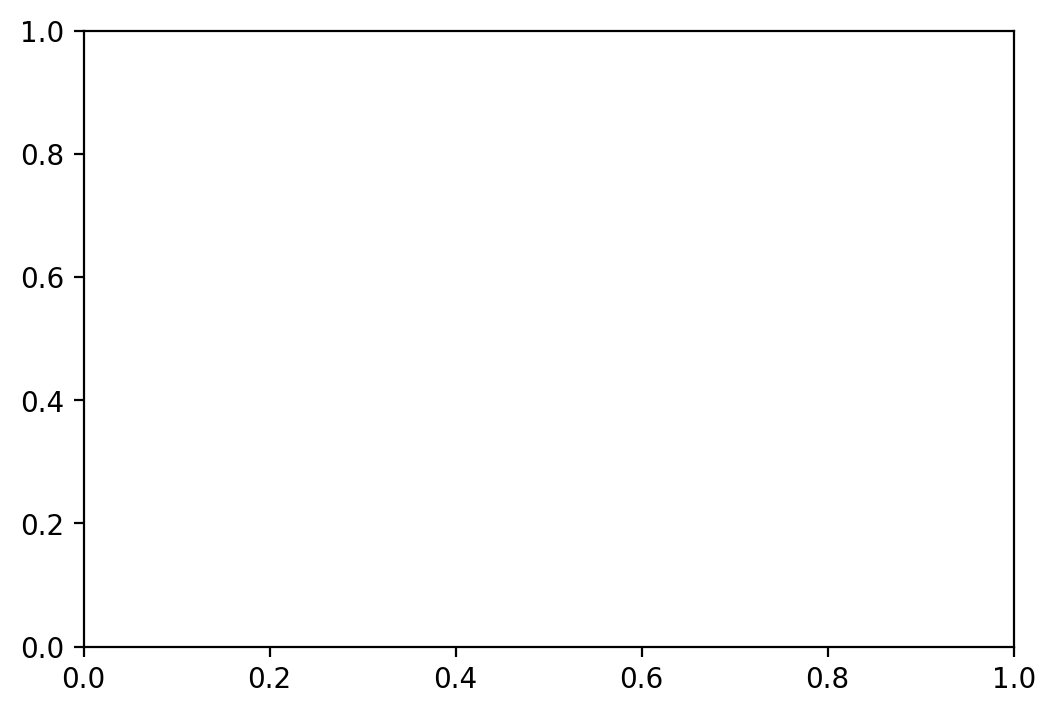

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

slice_P1 = slice('1980-01', '1999-12')
slice_P2 = slice('2000-01', '2010-12')
ccr_obs_P1 = xcorr(obs_RO_ds.sel(time=slice_P1), obs_RO_ds['Nino34'].sel(time=slice_P1), maxlags=36)
ccr_obs_P2 = xcorr(obs_RO_ds.sel(time=slice_P2), obs_RO_ds['Nino34'].sel(time=slice_P2), maxlags=36)

sel_var = 'WWV'
ax.plot(ccr_obs_P1.lag, ccr_obs_P1[sel_var], c='red', marker='.', label=f'ORAS5 {slice_P1.start[0:4]}-{slice_P1.stop[0:4]}')
ax.plot(ccr_obs_P2.lag, ccr_obs_P2[sel_var], c='blue', marker='.', label=f'ORAS5 {slice_P2.start[0:4]}-{slice_P2.stop[0:4]}')

ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (months)')
ax.set_xticks(np.arange(-36, 37, step=6))
ax.text(0.25, 0.1,'WWV leads Nino34', ha='center', transform=ax.transAxes, fontsize='large')
ax.text(0.75, 0.75,'Nino34 leads WWV', ha='center', transform=ax.transAxes, fontsize='large')
ax.set_xlim([-24, 24])
ax.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--', c='gray')
ax.legend()

### 1.5 ENSO spectrum analysis

Thomson’s multitaper power spectral density (PSD) estimate
See pmtm in `XRO_utils.py`

**Combination mode**

Stuecker, M. F., Timmermann, A., Jin, F.-F., McGregor, S., & Ren, H.-L. (2013). A combination mode of the annual cycle and the El Niño/Southern Oscillation. Nature Geoscience, 6(7), 540–544. https://doi.org/10.1038/ngeo1826


In [ ]:
psd_obs, psd_sig_obs, psd_ci_obs = pmtm( obs_RO_ds['Nino34'], dim='time', dt=1/12, nw=5)
print(psd_obs.coords)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.loglog(psd_obs.freq, psd_obs, lw=1.5, color='k', label='ORAS5')
ax.plot(psd_sig_obs.freq, psd_sig_obs, lw=1., color='k', linestyle='--', label='ORAS5 95% CL')

per = [50,20,10,5,2,1,0.5,0.2]
xt = 1.0/np.array(per)
ax.set_xticks(xt)
ax.set_xticklabels(map(str, per))
ax.set_ylabel('PSD (℃$^2$/cycles per month)')
ax.set_xlabel('Period (year)')
ax.set_xlim([1/20, 5])
ax.set_ylim([1e-3, 10])

ax.legend(loc='right')

y_min, y_max = ax.get_ylim()
Mfreq_enso = np.array([1/2.5, 1/5.5])
Mfreq_fplus = 1 + Mfreq_enso
Mfreq_fmins = 1 - Mfreq_enso

ax.fill_between(Mfreq_enso, y_min, y_max, fc='gray', alpha=0.4)
ax.fill_between(Mfreq_fplus, y_min, y_max, fc='gray',  alpha=0.2)
ax.fill_between(Mfreq_fmins, y_min, y_max, fc='gray', alpha=0.2)

ax.text(np.mean(Mfreq_enso)*0.9, y_max, '$f_{E}=$\n 2.5-5.5 yrs', ha='center', va='top')
ax.text(np.mean(Mfreq_fplus)+0.1, y_max, '$1+f_{E}$', ha='center', va='top')

ax.text(np.mean(Mfreq_fmins), y_max, '$1-f_{E}$ = \n 15-20 months', ha='center', va='top')
ax.set_title('Spectrum of Niño3.4 SST anomaly')

## 2. RO equations and its forms in XRO/CRO framework

### 2.1 Master RO equations

$$
\frac{dT}{dt} = R T + F_1 h + b_{T} T^2 - c_{T} T^3 + d_{T} T H + \sigma_T (1+B*H(T)*T)\xi_T
$$

$$
\frac{dh}{dt} = -\varepsilon h - F_2 T - b_h T^2 + \sigma_h \xi_h
$$

Two indices are used to describe the oscillatory behaviour of ENSO. 
 - **$T$**: Sea surface temperature (SST) anomalies averaged over the Niño3.4 region 170°–120° W, 5° S–5° N
 - **$h$** Thermocline depth anomalies averaged over the equatorial Pacific 120° E–80° W, 5° S–5° N, that is, the WWV index (with a constant factor of the area it covers).

<div style="border-left: 4px solid #FFA500; background-color: #FFF3CD; padding: 10px;">
    <strong>Choices of T and h:
    </strong>
    Following Zhao et al. (2024, Nature), we use Nino34 and WWV as ENSO state vectors in this notebook. You are welcome to try different versions and explore the similarities and differences. 
</div>


### 2.2 RO equations in XRO framework

Following Zhao et al. (2024), the standard RO include the ENSO state vectors which include
$X_{ENSO}=[T_{ENSO}, WWV]$ 


**RO Equation Forms in the XRO Framework**

The XRO model form : dX/dt = L * X + NRO_T + NRO_H + \xi


**Linear Operators**  
The linear operator **L** is defined as:  
\begin{pmatrix}  
L_{11} & L_{12} \\  
L_{21} & L_{22}  
\end{pmatrix}  

which simplifies to:  

\begin{pmatrix}  
R & F_1 \\  
- F_2 & -\varepsilon  
\end{pmatrix}  

where:  
$L_{11} = R, \quad L_{12} = F_1, \quad L_{21} = -F_2, \quad L_{22} = -\varepsilon$

**Nonlinear Operators** 
- maskNT set the choice of nonlinear terms in ENSO's T equation (five types: T2, T*H, T^3, T^2*H, T*H^2)
- maskNH set the choice of nonlinear terms is ENSO's H equation (five types: T2, T*H, T^3, T^2*H, T*H^2)

For example, 
    
    maskNT = [], maskNH = [] is linear model with nonlinear parameters to zero
    
    maskNT = ['T2', 'TH', 'T3'], maskNH = ['T2'] the master RO equations

    
> The standard **XRO** model in *Zhao et al. (2024)* masks **ENSO's SST**, **IOD's SST**, and the **T\*H term** in the ENSO SST equation:  
      maskNT = ['T2', 'TH'], maskNH = [], maskb=['IOD']

Here we include two versions of XRO model framework:

- RO model with annual mean, and annual cycle components (XRO_ac1)
- RO model with annual mean component only (XRO_ann)

>**Notes**
>1. The monthly time series is used to train the XRO model, so we set `ncycle=12`. Therefore, the XRO simulate/reforecast output is also monthly mean time series.
>2. It should be noted that the XRO framework accept higher resolution data such as (ncycle=52 for weekly data and ncycle=365 for daily noleap data), similarly the output of simulate/reforecast will be weakly or daily automatically.
>3. XRO framework also supports semiannual cycle : XRO model with annual mean, annual cycle, and semi-annual cycles components (`XRO_ac2=XRO(ncycle=12, ac_order=2, is_forward=True)`)



In [ ]:
XRO_ac1 = XRO(ncycle=12, ac_order=1, is_forward=True)
XRO_ann = XRO(ncycle=12, ac_order=0, is_forward=True)

### 2.3 RO fitting on observations

#### Linear RO model (LRO and LROann), LROann is the verson without annual cycle
We fitted the RO model with observed Nino34 and WWV indices with standard linear version

$$
\frac{dT}{dt} = R T + F_1 h  + \sigma_T (1+B*H(T)*T)\xi_T
$$

$$
\frac{dh}{dt} = -\varepsilon h - F_2 T + \sigma_h \xi_h
$$

Linear RO version
- maskNT is nonlinear terms in ENSO's T equation
- maskNH is nonlinear terms in ENSO's H equation


In [ ]:
fit_LRO = XRO_ac1.fit_matrix(obs_RO_ds, maskNT=[], maskNH=[])
fit_LRO_ds = XRO_ac1.get_RO_parameters(fit_LRO)
fit_LRO_ds

In [ ]:
fit_LROann = XRO_ann.fit_matrix(obs_RO_ds, maskNT=[], maskNH=[])
fit_LROann_ds = XRO_ann.get_RO_parameters(fit_LROann)
fit_LROann_ds

#### Nonlinear RO model (NRO and NROann), NROann is the verson without annual cycle
We fitted the RO model with observed Nino34 and WWV indices with full complexities

$$
\frac{dT}{dt} = R T + F_1 h + b_{T} T^2 + \sigma_T (1+B*H(T)*T)\xi_T
$$

$$
\frac{dh}{dt} = -\varepsilon h - F_2 T + b_h T^2 + \sigma_h \xi_h
$$

In [ ]:
fit_NRO = XRO_ac1.fit_matrix(obs_RO_ds, maskNT=['T2'], maskNH=['T2'])
fit_NRO_ds = XRO_ac1.get_RO_parameters(fit_NRO)
fit_NRO_ds

In [ ]:
fit_NROann = XRO_ann.fit_matrix(obs_RO_ds, maskNT=['T2'], maskNH=['T2'])
fit_NROann_ds = XRO_ann.get_RO_parameters(fit_NROann)
fit_NROann_ds

### 2.4 ENSO linear growth rate and seasonal synchronization

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)

fit_LRO_ds['BJ_ac'].plot(c='red',  marker='o', label='LRO', ax=ax, zorder=10)
fit_LROann_ds['BJ_ac'].plot(c='red', ls='--', label='LROann', ax=ax, zorder=1)

fit_NRO_ds['BJ_ac'].plot(c='blue', marker='s', label='NRO', ax=ax, zorder=20)
fit_NROann_ds['BJ_ac'].plot(c='blue', ls='--', label='NROann', ax=ax, zorder=2)
# ax.set_ylim([-2, 1])
ax.set_ylabel('ENSO growth rate (year$^{-1}$)')
ax.legend()

axR=ax.twinx()
axR.plot(x_month, stddevAC_obs_ds[sel_var], lw=5, c='gray', label='ORAS5', alpha=0.5)
axR.tick_params(axis='y', colors='gray', labelcolor='gray')
axR.set_ylim([0.4, 1.4])
axR.set_ylabel('Nino34 seasonal standard deviation (℃)', color='gray')

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('Calendar Month')
ax.set_title('ENSO growth rate & seasonal synchronization')

## 3. RO stochastic simulations with different complexities

### 3.1 Validating the fitted NRO model's ability to reproduce observed ENSO properties.

`XRO_ac2.simulate`
Stochastic simulations (as an example, initial from observed 1979-01, each model run 100 years with 100 realiazations)

- set `seed` to int number to get the exact same result (default is None)
- set `is_xi_stdac=False` if consider seasonal modulation of noise amplitde (default is None)

The output is archived as monthly mean of state vectors

In [ ]:
seed = 1000
sim_NRO = XRO_ac1.simulate(fit_ds=fit_NRO, X0_ds=obs_RO_ds.isel(time=0), 
                           nyear=100, ncopy=100, noise_type='red', 
                           seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True)

#### Reproduce ENSO irregular interannual oscillations (NRO)
Show the time series of each member

In [ ]:
nmember = 10

ncol = 2
nrow = nmember//ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*3, nrow*1.5), sharey=True, sharex=True, layout='compressed')

for i, ax in enumerate(axes.flat):
    plot_above_below_shading(sim_NRO.isel(member=i*2)['Nino34'], c='black', lw=0.5, ax=ax)
    # ax.set_xlabel('Model years')
    ax.set_xlim([1, 102])
    ax.set_xticks(np.arange(0, 101, step=10))
    ax.set_ylabel('Nino34 SSTA (degC)')
    ax.set_title(f'member={2*i}')

#### Reproduce the observed ENSO seasonal synchronization

In [ ]:
stddevAC_NRO_ds = sim_NRO.groupby('time.month').std('time')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plot_fill_between(stddevAC_NRO_ds[sel_var], xtime=x_month, ax=ax, label='NRO')
# axR=ax.twinx()
# fit_NRO_ds['BJ_ac'].plot(c='red', marker='.', ax=axR)
# axR.tick_params(axis='y', colors='red', labelcolor='red')
# # axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
ax.set_ylim([0.4, 1.4])
ax.set_title('ENSO seasonal synchronization')
ax.legend()

#### Reproduce the observed ENSO skewness

In [ ]:
skew_NRO_ds = sim_NRO.skew('time')

sel_var = 'Nino34'
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, sharex=True, layout='compressed')

bins = np.arange(-2, 2.01, step=0.1)
model_lists = [skew_NRO_ds]
model_labels = ['NRO']

for i, model_ds  in enumerate(model_lists):
    sns.histplot(model_ds[sel_var], stat='density', bins=bins, ax=ax, alpha=0.9, label=model_labels[i])

ax.axvline(skew_obs_ds[sel_var], c='black', lw=2)
ax.set_xlim([-1.5, 1.5])
ax.set_xlabel(f'{sel_var} skewness')
ax.text( skew_obs_ds[sel_var]+0.01, 1.5, 'ORAS5', rotation=90, fontsize=14)
ax.legend()

#### Reproduce the ENSO SST autocorrelation

In [ ]:
ccr_NRO_ds = xcorr(sim_NRO, sim_NRO['Nino34'], maxlags=36)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sel_var = 'Nino34'
ax.plot(ccr_obs_ds.lag, ccr_obs_ds[sel_var], c='black', marker='.', label='ORAS5 1979-2024')
ax.plot(ccr_obs_P1.lag, ccr_obs_P1[sel_var], c='gray', marker='.', label=f'ORAS5 {slice_P1.start[0:4]}-{slice_P1.stop[0:4]}')
# ax.plot(ccr_obs_P2.lag, ccr_obs_P2[sel_var], c='blue', marker='.', label=f'ORAS5 {slice_P2.start[0:4]}-{slice_P2.stop[0:4]}')

plot_fill_between(ccr_NRO_ds[sel_var], dim='member', c='orangered',
                  alpha=0.2, xtime=ccr_NRO_ds.lag, ax=ax, option=0, label='NRO')

ax.set_title('Nino34 autocorrelation')
ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (months)')
ax.set_xticks(np.arange(-36, 37, step=6))
ax.set_xlim([0, 36])
ax.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--', c='gray')
ax.legend()

#### Reproduce the observed ENSO SST-WWV relationships

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sel_var = 'WWV'
ax.plot(ccr_obs_ds.lag, ccr_obs_ds[sel_var], c='black', marker='.', label='ORAS5 1979-2024')
ax.plot(ccr_obs_P1.lag, ccr_obs_P1[sel_var], c='gray', marker='.', label=f'ORAS5 {slice_P1.start[0:4]}-{slice_P1.stop[0:4]}')
# ax.plot(ccr_obs_P2.lag, ccr_obs_P2[sel_var], c='blue', marker='.', label=f'ORAS5 {slice_P2.start[0:4]}-{slice_P2.stop[0:4]}')

plot_fill_between(ccr_NRO_ds[sel_var], dim='member', c='orangered',
                  alpha=0.2, xtime=ccr_NRO_ds.lag, ax=ax, option=0, label='NRO')

ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (months)')
ax.set_xticks(np.arange(-36, 37, step=6))
ax.text(0.25, 0.1,'WWV leads Nino34', ha='center', transform=ax.transAxes, fontsize='large')
ax.text(0.75, 0.75,'Nino34 leads WWV', ha='center', transform=ax.transAxes, fontsize='large')
ax.set_xlim([-24, 24])
ax.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--', c='gray')
ax.legend()

#### Reproduce the observed ENSO spectrum peak and combination tone

In [ ]:
psd_NRO, psd_sig_NRO, psd_ci_NRO = pmtm( sim_NRO['Nino34'], dim='time', dt=1/12, nw=5)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.loglog(psd_obs.freq, psd_obs, lw=1.5, color='k', label='ORAS5')
ax.plot(psd_sig_obs.freq, psd_sig_obs, lw=1., color='k', linestyle='--', label='ORAS5 95% CL')

ax.loglog(psd_NRO.freq, psd_NRO.mean('member'), lw=1.5, color='orangered', label='NRO')
ax.fill_between(psd_NRO.freq, psd_NRO.quantile(0.1, dim='member'), 
                psd_NRO.quantile(0.9, dim='member'), fc='orangered', label='NRO 10-90% spread', alpha=0.4)
ax.semilogx(psd_sig_NRO.freq, psd_sig_NRO.mean('member'), color='orangered', linestyle='--', label='NRO 95% CL')

per = [50,20,10,5,2,1,0.5,0.2]
xt = 1.0/np.array(per)
ax.set_xticks(xt)
ax.set_xticklabels(map(str, per))
ax.set_ylabel('PSD (℃$^2$/cycles per month)')
ax.set_xlabel('Period (year)')
ax.set_xlim([1/20, 5])
ax.set_ylim([1e-3, 10])

ax.legend(loc='center right', fontsize='small', bbox_to_anchor=(1.4, 0.5))

y_min, y_max = ax.get_ylim()
Mfreq_enso = np.array([1/2.5, 1/5.5])
Mfreq_fplus = 1 + Mfreq_enso
Mfreq_fmins = 1 - Mfreq_enso

ax.fill_between(Mfreq_enso, y_min, y_max, fc='gray', alpha=0.4)
ax.fill_between(Mfreq_fplus, y_min, y_max, fc='gray',  alpha=0.2)
ax.fill_between(Mfreq_fmins, y_min, y_max, fc='gray', alpha=0.2)

ax.text(np.mean(Mfreq_enso)*0.9, y_max, '$f_{E}=$\n 2.5-5.5 yrs', ha='center', va='top')
ax.text(np.mean(Mfreq_fplus)+0.1, y_max, '$1+f_{E}$', ha='center', va='top')

ax.text(np.mean(Mfreq_fmins), y_max, '$1-f_{E}$ = \n 15-20 months', ha='center', va='top')
ax.set_title('Spectrum of Niño3.4 SST anomaly')

### 3.2 ENSO seasonal phase locking & sensitivity to parameters (R’s seasonal cycle)

In the following code block, we calcualte the Nino34 seasonal standard deviation (stddev) for observation (ORAS5), NRO  simulation, and NROann simulation (no annual cycle in RO operators).

- As shown in the figure, RO accurately simulates observed ENSO seasonal synchronization (comoare black curve and red curve)
- If we don't include the seasonal cycle in the RO operators, there is no seasonal synchronization (blue curve)

In [ ]:
g = fit_NRO['Lac'].plot(col='rankx', row='ranky', marker='.', sharey=False, sharex=True, figsize=(6, 4))
ylabel_arrs = ['$R$', '$F_1$', '$-F_2$', '$-\\varepsilon$']
for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(ylabel_arrs[i])
    ax.set_xticks(fit_NRO.cycle)
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    ax.set_xlabel('Calendar month')
    
g.fig.suptitle('RO linear parameters (total)', y=1., fontweight='bold')
g.fig.tight_layout()

In [ ]:
g = fit_NRO['Lcomp'].sel(ac_rank=0).plot(col='rankx', row='ranky', marker='.', sharey=False, sharex=True, figsize=(6, 4))
ylabel_arrs = ['$R$', '$F_1$', '$-F_2$', '$-\\varepsilon$']
for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(ylabel_arrs[i])

    ax.set_xticks(fit_NRO.cycle)
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    ax.set_xlabel('Calendar month')
    
g.fig.suptitle('RO linear parameters (annual mean component)', y=1., fontweight='bold')
g.fig.tight_layout()

In [ ]:
g = fit_NRO['Lcomp'].sel(ac_rank=1).plot(col='rankx', row='ranky', marker='.', sharey=False, sharex=True, figsize=(6, 4))
ylabel_arrs = ['$R$', '$F_1$', '$-F_2$', '$-\\varepsilon$']
for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(ylabel_arrs[i])
    ax.set_xticks(fit_NRO.cycle)
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    ax.set_xlabel('Calendar month')
    
g.fig.suptitle('RO linear parameters (annual cycle component)', y=1., fontweight='bold')
g.fig.tight_layout()


In [ ]:
# model with full annual cycle
# fit_NROann = XRO_ann.fit_matrix(obs_RO_ds, maskNT=['T2'], maskNH=['T2'])
fit_NROann = fit_NRO.copy(deep=True)
fit_NROann['Lac'] = fit_NRO['Lcomp'].sel(ac_rank=0)
fit_NROann = XRO_ann.set_NRO_annualmean(fit_NROann)

sim_NROann = XRO_ann.simulate(fit_ds=fit_NROann, X0_ds=obs_RO_ds.isel(time=0), 
                           nyear=100, ncopy=100, noise_type='red', 
                           seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True) 

# calculate seasonal varying stddev
stddevAC_NRO_ds = sim_NRO.groupby('time.month').std('time')
stddevAC_NROann_ds = sim_NROann.groupby('time.month').std('time')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plot_fill_between(stddevAC_NRO_ds[sel_var], xtime=x_month, ax=ax, label='NRO')
plot_fill_between(stddevAC_NROann_ds[sel_var], xtime=x_month, ax=ax, c='blue', label='NROann')
# axR=ax.twinx()
# fit_NRO_ds['BJ_ac'].plot(c='red', marker='.', ax=axR)
# axR.tick_params(axis='y', colors='red', labelcolor='red')
# # axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
ax.set_ylim([0.4, 1.4])
ax.set_title('ENSO seasonal synchronization')
ax.legend()

<span style="font-size:24px; font-weight:bold; color:red;">Question: Which components are responsible for the observed ENSO SST seasonal synchronization?</span> 

To understand this, we can perturb the RO parameters and re-run the RO simulations

#### sensitivity to Linear RO parameters

In [ ]:

def petrub_annual_cycle_simulation(para = 'R', seed = 1000):
    para_slice_dicts = {}
    para_slice_dicts['R'] = dict(rankx=1, ranky=1)
    para_slice_dicts['F1'] = dict(rankx=2, ranky=1)
    para_slice_dicts['F2'] = dict(rankx=1, ranky=2)
    para_slice_dicts['epsilon'] = dict(rankx=2, ranky=2)

    sel_loc = para_slice_dicts[para]
    
    # model with full annual cycle
    fit_perturb = fit_NROann.copy(deep=True)
    fit_perturb['Lac'].loc[sel_loc] = fit_NRO['Lac'].loc[sel_loc]

    seed = 1000
    sim_perturb = XRO_ann.simulate(fit_ds=fit_perturb, X0_ds=obs_RO_ds.isel(time=0), 
                                  nyear=100, ncopy=100, noise_type='red', 
                                  seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True)

    
    return sim_perturb

sel_para = 'R'

sim_NRO_Rac = petrub_annual_cycle_simulation(para=sel_para)
stddevAC_NRO_Rac_ds = sim_NRO_Rac.groupby('time.month').std('time')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='gray', lw=4, label='ORAS5')

plot_fill_between(stddevAC_NRO_ds[sel_var], xtime=x_month, ax=ax, lw=2, label='NRO')
plot_fill_between(stddevAC_NROann_ds[sel_var], xtime=x_month, ax=ax, lw=2, c='blue', label='NROann')
plot_fill_between(stddevAC_NRO_Rac_ds[sel_var], xtime=x_month, ax=ax, lw=2,  c='magenta', label=f'NRO onlyAC {sel_para}')
# axR=ax.twinx()
# fit_NRO_ds['BJ_ac'].plot(c='red', marker='.', ax=axR)
# axR.tick_params(axis='y', colors='red', labelcolor='red')
# # axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
# ax.set_ylim([0.4, 1.8])
ax.set_title('ENSO seasonal synchronization')
ax.legend()

#### Annual cycle determine the cominbation mode/tones

In [ ]:
psd_NROann, psd_sig_NROann, psd_ci_NROann = pmtm( sim_NROann['Nino34'], dim='time', dt=1/12, nw=5)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.loglog(psd_obs.freq, psd_obs, lw=1.5, color='k', label='ORAS5')
ax.plot(psd_sig_obs.freq, psd_sig_obs, lw=1., color='k', linestyle='--', label='ORAS5 95% CL')

ax.loglog(psd_NRO.freq, psd_NRO.mean('member'), lw=1.5, color='orangered', label='NRO')
ax.fill_between(psd_NRO.freq, psd_NRO.quantile(0.1, dim='member'), 
                psd_NRO.quantile(0.9, dim='member'), fc='orangered', label='NRO 10-90% spread', alpha=0.4)
ax.semilogx(psd_sig_NRO.freq, psd_sig_NRO.mean('member'), color='orangered', linestyle='--', label='NRO 95% CL')

ax.loglog(psd_NROann.freq, psd_NROann.mean('member'), lw=1.5, color='blue', label='NROann')
ax.fill_between(psd_NROann.freq, psd_NROann.quantile(0.1, dim='member'), 
                psd_NROann.quantile(0.9, dim='member'), fc='blue', label='NROann 10-90% spread', alpha=0.4)
ax.semilogx(psd_sig_NROann.freq, psd_sig_NROann.mean('member'), color='blue', linestyle='--', label='NROann 95% CL')


per = [50,20,10,5,2,1,0.5,0.2]
xt = 1.0/np.array(per)
ax.set_xticks(xt)
ax.set_xticklabels(map(str, per))
ax.set_ylabel('PSD (℃$^2$/cycles per month)')
ax.set_xlabel('Period (year)')
ax.set_xlim([1/20, 5])
ax.set_ylim([1e-3, 10])

ax.legend(loc='center right', fontsize='small', bbox_to_anchor=(1.4, 0.5))

y_min, y_max = ax.get_ylim()
Mfreq_enso = np.array([1/2.5, 1/5.5])
Mfreq_fplus = 1 + Mfreq_enso
Mfreq_fmins = 1 - Mfreq_enso

ax.fill_between(Mfreq_enso, y_min, y_max, fc='gray', alpha=0.4)
ax.fill_between(Mfreq_fplus, y_min, y_max, fc='gray',  alpha=0.2)
ax.fill_between(Mfreq_fmins, y_min, y_max, fc='gray', alpha=0.2)

ax.text(np.mean(Mfreq_enso)*0.9, y_max, '$f_{E}=$\n 2.5-5.5 yrs', ha='center', va='top')
ax.text(np.mean(Mfreq_fplus)+0.1, y_max, '$1+f_{E}$', ha='center', va='top')

ax.text(np.mean(Mfreq_fmins), y_max, '$1-f_{E}$ = \n 15-20 months', ha='center', va='top')
ax.set_title('Spectrum of Niño3.4 SST anomaly')


### 3.3 ENSO asymmetry & sensitivity to parameters (B, b) (10 min)

#### Sensitivity to B

In [ ]:
seed = 1000
B_value_arrs = [0, 0.2, 0.4, 0.6, 0.8]
for i, B_value in enumerate(B_value_arrs):
    sim_LRO_senB = XRO_ann.simulate(fit_ds=fit_LRO, X0_ds=obs_RO_ds.isel(time=0), 
                               nyear=100, ncopy=100, noise_type='white', 
                               seed=seed, is_xi_stdac=False, xi_B=B_value, is_heaviside=True)
    tmp_stddev = sim_LRO_senB.std('time').assign_coords({'B': B_value})
    tmp_skew = sim_LRO_senB.skew('time').assign_coords({'B': B_value})

    if i==0:
        senB_stddev_ds = tmp_stddev
        senB_skew_ds = tmp_skew
    else:
        senB_stddev_ds = xr.concat([senB_stddev_ds, tmp_stddev], dim='B')
        senB_skew_ds = xr.concat([senB_skew_ds, tmp_skew], dim='B')
senB_stddev_ds

> **The model may be unstable if you increase B too large**
> 
> See Levine, A. F. Z., & Jin, F.-F. (2010). Noise-Induced Instability in the ENSO Recharge Oscillator. Journal of the Atmospheric Sciences, 67(2), 529–542. https://doi.org/10.1175/2009JAS3213.1

Noise-induced instability of ENSO
<p align="center">
    <img src="https://journals.ametsoc.org/view/journals/atsc/67/2/inline-i1520-0469-67-2-529-e6.gif" width="50%">
</p>


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), layout='compressed')

ax = axes[0]
plot_fill_between(senB_stddev_ds['Nino34'], xtime=senB_stddev_ds.B, marker='o',  dim='member', option=0.1, ax=ax)
ax.set_ylim([0.5, 1])
ax.set_ylabel('Nino34 stddev (degC)')

ax = axes[1]
plot_fill_between(senB_skew_ds['Nino34'], xtime=senB_skew_ds.B, marker='o',  dim='member', option=0.1, ax=ax)
ax.set_ylim([-0.9, 0.9])
ax.set_ylabel('Nino34 Skewness')
ax.axhline(0,ls='--')

for ax in axes.flat:
    ax.set_xlabel('B')

#### Sensitivity to b

In [ ]:
fit_NRO0 = XRO_ann.fit_matrix(obs_RO_ds, maskNT=['T2'], maskNH=['T2'])
fit_NRO0['NROT_Lac'].sel(nro_form='T2')

In [ ]:
fit_LROann['NROT_Lac'].loc[dict(nro_form='T2')] = 1
fit_LROann['NROT_Lac'].loc[dict(nro_form='T2')] 

In [ ]:
seed = 2000
bT_value_arrs = [0, 0.09, 0.18, 0.36, 0.54]
for i, bT_value in enumerate(bT_value_arrs):
    fit_pert = fit_LROann.copy(deep=True)
    fit_pert['NROT_Lac'].loc[dict(nro_form='T2')] = bT_value

    # if the model is unstable, cubic nonlinearitiy is needed
    fit_pert['NROT_Lac'].loc[dict(nro_form='T3')] = -0.1

    sim_LRO_senbT = XRO_ann.simulate(fit_ds=fit_pert, X0_ds=obs_RO_ds.isel(time=0), 
                               nyear=100, ncopy=100, noise_type='white', 
                               seed=seed, is_xi_stdac=False, xi_B=0, is_heaviside=False)
    tmp_stddev = sim_LRO_senbT.std('time').assign_coords({'bT': bT_value})
    tmp_skew = sim_LRO_senbT.skew('time').assign_coords({'bT': bT_value})

    if i==0:
        senbT_stddev_ds = tmp_stddev
        senbT_skew_ds = tmp_skew
    else:
        senbT_stddev_ds = xr.concat([senbT_stddev_ds, tmp_stddev], dim='bT')
        senbT_skew_ds = xr.concat([senbT_skew_ds, tmp_skew], dim='bT')
senbT_stddev_ds

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), layout='compressed')

ax = axes[0]
plot_fill_between(senbT_stddev_ds['Nino34'], xtime=senbT_stddev_ds.bT, marker='o',  dim='member', option=0.1, ax=ax)
ax.set_ylim([0.5, 1])
ax.set_ylabel('Nino34 stddev (degC)')

ax = axes[1]
plot_fill_between(senbT_skew_ds['Nino34'], xtime=senbT_skew_ds.bT, marker='o',  dim='member', option=0.1, ax=ax)
ax.set_ylim([-0.9, 0.9])
ax.set_ylabel('Nino34 Skewness')
ax.axhline(0,ls='--')

for ax in axes.flat:
    ax.set_xlabel('bT')

### 3.4 ENSO spectrum, auto-correlation, SST-WWV relationships & sensitivity to parameters (F₁, F₂, R, ε) (10 min)

>*See Zhao et al. (2021) the analytic formulation of ENSO RO parameters determine the ENSO perodicity and ENSO SST-WWV relationships*
>
>Zhao, S., Jin, F.-F., & Stuecker, M. F. (2021). Understanding Lead Times of Warm Water Volumes to ENSO Sea Surface Temperature Anomalies. Geophysical Research Letters, 48(19), e2021GL094366. https://doi.org/10.1029/2021GL094366
  

In [ ]:
def calculate_BWJ(fit_ds):
    BJ = 0.5 * ( fit_ds['R'] - fit_ds['epsilon'] )
    WF = np.sqrt( fit_ds['F1'] * fit_ds['F2'] - ( fit_ds['R'] + fit_ds['epsilon'] )**2/4 )
    WJ = np.pi*2/np.sqrt( fit_ds['F1'] * fit_ds['F2'] - ( fit_ds['R'] + fit_ds['epsilon'] )**2/4 )
    out_ds = xr.Dataset({'BJ': BJ, 'WF': WF, 'WJ': WJ})
    out_ds['BJ'].attrs['units'] = 'year**-1'
    out_ds['WF'].attrs['units'] = 'year**-1'
    out_ds['WJ'].attrs['units'] = 'year'
    return out_ds

# linear RO
fit_LRO = XRO_ann.fit_matrix(obs_RO_ds, maskNT=[], maskNH=[])
fit_LRO_ds = XRO_ann.get_RO_parameters(fit_LRO)
fit_LRO_BWJ_ds = calculate_BWJ(fit_LRO_ds.mean('cycle'))
print(fit_LRO_BWJ_ds)

sim_LRO = XRO_ann.simulate(fit_ds=fit_LRO, X0_ds=obs_RO_ds.isel(time=0), 
                           nyear=100, ncopy=100, noise_type='red', 
                           seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True)
psd_LRO, psd_sig_LRO, psd_ci_LRO = pmtm( sim_LRO['Nino34'], dim='time', dt=1/12, nw=5)
ccr_LRO_ds = xcorr(sim_LRO, sim_LRO['Nino34'], maxlags=36)

#
# model with full annual cycle
fit_LROsens = fit_LRO.copy(deep=True)

# ## R
fit_LROsens['Lac'].loc[dict(rankx=1, ranky=1)] = fit_LRO['Lac'].loc[dict(rankx=1, ranky=1)] 

# F1
fit_LROsens['Lac'].loc[dict(rankx=2, ranky=1)] = fit_LRO['Lac'].loc[dict(rankx=2, ranky=1)] * 2

# F2
fit_LROsens['Lac'].loc[dict(rankx=1, ranky=2)] = fit_LRO['Lac'].loc[dict(rankx=1, ranky=2)] 

# # epsilon
fit_LROsens['Lac'].loc[dict(rankx=2, ranky=2)] = fit_LRO['Lac'].loc[dict(rankx=2, ranky=2)] 

fit_LROsens_ds = XRO_ann.get_RO_parameters(fit_LROsens)
fit_LROsens_BWJ_ds = calculate_BWJ(fit_LROsens_ds.mean('cycle'))
print(fit_LROsens_BWJ_ds)

sim_LROsens = XRO_ann.simulate(fit_ds=fit_LROsens, X0_ds=obs_RO_ds.isel(time=0), 
                           nyear=100, ncopy=100, noise_type='red', 
                           seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True)

psd_LROsens, psd_sig_LROsens, psd_ci_LROsens = pmtm( sim_LROsens['Nino34'], dim='time', dt=1/12, nw=5)
ccr_LROsens_ds = xcorr(sim_LROsens, sim_LROsens['Nino34'], maxlags=36)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.loglog(psd_LRO.freq, psd_LRO.mean('member'), lw=1.5, color='orangered', label='LRO')
ax.fill_between(psd_LRO.freq, psd_LRO.quantile(0.1, dim='member'), 
                psd_LRO.quantile(0.9, dim='member'), fc='orangered', label='LRO 10-90% spread', alpha=0.4)
ax.semilogx(psd_sig_LRO.freq, psd_sig_LRO.mean('member'), color='orangered', linestyle='--', label='LRO 95% CL')


ax.loglog(psd_LROsens.freq, psd_LROsens.mean('member'), lw=1.5, color='deepskyblue', label='LROsens')
ax.fill_between(psd_LROsens.freq, psd_LROsens.quantile(0.1, dim='member'), 
                psd_LROsens.quantile(0.9, dim='member'), fc='deepskyblue', label='LROsens 10-90% spread', alpha=0.4)
ax.semilogx(psd_sig_LROsens.freq, psd_sig_LROsens.mean('member'), color='deepskyblue', linestyle='--', label='LROsens 95% CL')

per = [50,20,10,5,2,1,0.5,0.2]
xt = 1.0/np.array(per)
ax.set_xticks(xt)
ax.set_xticklabels(map(str, per))
ax.set_ylabel('PSD (℃$^2$/cycles per month)')
ax.set_xlabel('Period (year)')
ax.set_xlim([1/20, 5])
ax.set_ylim([1e-3, 10])

ax.axvline(1/fit_LRO_BWJ_ds['WJ'].values, c='red', lw=3)
ax.text(1/fit_LRO_BWJ_ds['WJ'].values-0.01, 2e-3, f"LRO {fit_LRO_BWJ_ds['WJ'].values:.1f} yr", c='red', ha='right', rotation=90)

ax.axvline(1/fit_LROsens_BWJ_ds['WJ'].values, c='deepskyblue', lw=3)
ax.text(1/fit_LROsens_BWJ_ds['WJ'].values+0.01, 2e-3, f"LROsens {fit_LROsens_BWJ_ds['WJ'].values:.1f} yr", c='deepskyblue', ha='left', rotation=90)


ax.legend(loc='center right', fontsize='small', bbox_to_anchor=(1.4, 0.5))

# y_min, y_max = ax.get_ylim()
# Mfreq_enso = np.array([1/2.5, 1/5.5])
# Mfreq_fplus = 1 + Mfreq_enso
# Mfreq_fmins = 1 - Mfreq_enso

# ax.fill_between(Mfreq_enso, y_min, y_max, fc='gray', alpha=0.4)
# ax.fill_between(Mfreq_fplus, y_min, y_max, fc='gray',  alpha=0.2)
# ax.fill_between(Mfreq_fmins, y_min, y_max, fc='gray', alpha=0.2)

# ax.text(np.mean(Mfreq_enso)*0.9, y_max, '$f_{E}=$\n 2.5-5.5 yrs', ha='center', va='top')
# ax.text(np.mean(Mfreq_fplus)+0.1, y_max, '$1+f_{E}$', ha='center', va='top')

# ax.text(np.mean(Mfreq_fmins), y_max, '$1-f_{E}$ = \n 15-20 months', ha='center', va='top')
ax.set_title('Spectrum of Niño3.4 SST anomaly')

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), layout='compressed')

ax = axes[0]
sel_var = 'Nino34'
plot_fill_between(ccr_LRO_ds[sel_var], dim='member', c='orangered',
                  alpha=0.2, xtime=ccr_LRO_ds.lag, ax=ax, option=0, label='LRO')

plot_fill_between(ccr_LROsens_ds[sel_var], dim='member', c='deepskyblue',
                  alpha=0.2, xtime=ccr_LROsens_ds.lag, ax=ax, option=0, label='LROsens')
ax.set_title("Nino34 autocorrelation")

ax = axes[1]
sel_var = 'WWV'
plot_fill_between(ccr_LRO_ds[sel_var], dim='member', c='orangered',
                  alpha=0.2, xtime=ccr_LRO_ds.lag, ax=ax, option=0, label='LRO')

plot_fill_between(ccr_LROsens_ds[sel_var], dim='member', c='deepskyblue',
                  alpha=0.2, xtime=ccr_LROsens_ds.lag, ax=ax, option=0, label='LROsens')
ax.set_title("Nino34-WWV cross-correlation")

for i, ax in enumerate(axes.flat):
    ax.set_ylabel('Correlation')
    ax.set_xlabel('Lag (months)')
    ax.set_xticks(np.arange(-36, 37, step=6))
    if i==1:
        ax.text(0.25, 0.1,'WWV leads Nino34', ha='center', transform=ax.transAxes, fontsize='large')
        ax.text(0.75, 0.75,'Nino34 leads WWV', ha='center', transform=ax.transAxes, fontsize='large')
    ax.set_xlim([-36, 36])
    ax.axhline(0, ls='--', c='gray')
    ax.axvline(0, ls='--', c='gray')
    ax.legend()

> **Reproduce sensitivity analysis from RO simulations?**  
>  
> Sensitivity of Wyrtki period and lead time of WWV to ENSO SST concerning RO parameters F1 and F2.  
>  
> *Figure 1B, F, and H from Zhao et al. (2021).*  

<p align="center">
    <img src="https://agupubs.onlinelibrary.wiley.com/cms/asset/ae9373e3-8a8e-44d1-9393-336d5cce0536/grl63080-fig-0001-m.jpg" width="50%">
</p>


## 4. RO reforecasting
### Reforecast function
reforecasting (as an example, initial from observed 1979-01 to 2023-10, each run 21 months)
- `fit_ds` is the trained operators, in which linear/nonlinear operators `Lac`/`NLac` as well as noise parameters `xi_std` and `xi_a1` will be used
- `init_ds` is initial condictions, the order of variables has been the same with the trained parameters
- determinsitc forecast by setting `noise_type='zero'` 
- stochastic forecast by setting `noise_type='red'` and `ncopy=100` (100 members)


#### calculate forecast skill performance using `climpred`


In [ ]:
def calc_forecast_skill(fcst_ds, ref_ds, metric='acc', is_mv3=True, comparison="e2o", 
                        by_month=False, verify_periods=slice('1979-01', '2022-12')):
    try:
        fcst_ds = fcst_ds.squeeze().drop('member')
    except:
        pass

    if is_mv3:
        fcst_ds = fcst_ds.rolling(init=3, center=True, min_periods=1).mean('init')
        ref_mv3 = ref_ds.rolling(time=3, center=True, min_periods=1).mean().dropna(dim='time')
    else:
        ref_mv3 = ref_ds

    hc_XRO = HindcastEnsemble(fcst_ds.sel(init=verify_periods))
    hc_XRO = hc_XRO.add_observations(ref_mv3)
    if by_month:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True, groupby='month')
    else:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True)
    try:
        del skill_XRO.attrs['skipna']
        skill_XRO = skill_XRO.drop('skill')
    except:
        pass

    for var in skill_XRO.data_vars:
        if var != 'model':
            skill_XRO[var].encoding['dtype'] = 'float32'
            skill_XRO[var].encoding['_FillValue'] = 1e20
    return skill_XRO

### 4.1 Out-of-sample correlation and RMSE skills
Train model using 1979-2000
Forecast verification using 2002-2024

In [ ]:
slice_train = slice('1979-01', '2000-12')
slice_verif = slice('2002-01', '2024-12')

fit_NRO_train = XRO_ac1.fit_matrix(obs_RO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_NRO_train, init_ds=obs_RO_ds.sel(time=slice_verif), 
                                          n_month=21, ncopy=1, noise_type='zero')

acc_NRO_outofsample = calc_forecast_skill(NRO_outofsample_fcst, obs_RO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2002-01', '2024-12'))
rmse_NRO_outofsample = calc_forecast_skill(NRO_outofsample_fcst, obs_RO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2002-01', '2022-12'))

In [ ]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
acc_NRO_outofsample[sel_var].plot(ax=ax, label='Out-of-Sample RO', c='deepskyblue', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0.2, 1.])
ax.set_xlim([1., 18])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('Out-of-sample Niño3.4 forecast \n correlation skill (2022-2024)')
ax.legend()

ax = axes[1]
rmse_NRO_outofsample[sel_var].plot(ax=ax, label='Out-of-Sample RO', c='deepskyblue', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 18])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('Out-of-sample Niño3.4 forecast \n RMSE skill (2022-2024)')
ax.legend()

### 4.2 Stocastic large ensmenble forecasts

In [ ]:
NRO_outofsample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_NRO_train, 
                                              init_ds=obs_RO_ds.sel(time=slice_verif), 
                                              n_month=21, ncopy=500, noise_type='red')

In [ ]:
date_arrs = ['2015-06', '2023-06']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_outofsample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_outofsample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_RO_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.1,  
                      c='magenta', marker='.', lw=3, label='500-members NRO stochastic forecasts', ax=ax)

    # Plot deterministic forecast
    ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()

## 5. RO model extensions (Extended nonlinear Recharge Oscillator, XRO)
[<img src="https://raw.githubusercontent.com/senclimate/XRO/af41cdef674028c948f7f2f8f21b4ef4d10141f0/XRO_logo.png" width="500">](https://github.com/senclimate/XRO)


Including the two way interactions between ENSO and other climate modes


$X_M = [T_{NPMM},T_{SPMM},T_{IOB},T_{IOD},T_{SIOD},T_{TNA},T_{ATL3},T_{SASD}]$, respectively.

See the defitions of those SST and WWV indices from Zhao et al. (2024). For briefty, here we use the observed indices from ORAS5 reanalysis for 1979-2024 as an exmaple.

In [ ]:
obs_XRO_ds = obs_ds[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']]
obs_XRO_ds

### 5.1 Out-of-sample XRO correlation and RMSE skills
Train model using 1979-2000
Forecast verification using 2002-2024

In [ ]:
slice_train = slice('1979-01', '2000-12')
slice_verif = slice('2002-01', '2024-12')

fit_XRO_train = XRO_ac1.fit_matrix(obs_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_outofsample_fcst = XRO_ac1.reforecast(fit_ds=fit_XRO_train, init_ds=obs_XRO_ds.sel(time=slice_verif), n_month=21, ncopy=1, noise_type='zero')


In [ ]:
acc_XRO_outofsample = calc_forecast_skill(XRO_outofsample_fcst, obs_RO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2002-01', '2024-12'))

rmse_XRO_outofsample = calc_forecast_skill(XRO_outofsample_fcst, obs_RO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2002-01', '2022-12'))

In [ ]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
acc_NRO_outofsample[sel_var].plot(ax=ax, label='Out-of-Sample RO', c='deepskyblue', lw=2)
acc_XRO_outofsample[sel_var].plot(ax=ax, label='Out-of-Sample XRO', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0.2, 1.])
ax.set_xlim([1., 18])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('Out-of-sample Niño3.4 forecast \n correlation skill (2022-2024)')
ax.legend()

ax = axes[1]
rmse_NRO_outofsample[sel_var].plot(ax=ax, label='Out-of-Sample RO', c='deepskyblue', lw=2)
rmse_XRO_outofsample[sel_var].plot(ax=ax, label='Out-of-Sample XRO', c='red', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 18])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('Out-of-sample Niño3.4 forecast \n RMSE skill (2022-2024)')
ax.legend()


In [ ]:
XRO_outofsample_fcst_ens = XRO_ac1.reforecast(fit_ds=fit_XRO_train, 
                                              init_ds=obs_XRO_ds.sel(time=slice_verif), 
                                              n_month=21, ncopy=500, noise_type='red')

### 5.2 Compare between XRO and RO


In [ ]:
date_arrs = ['2015-06', '2023-06', '2024-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_ens = NRO_outofsample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_d = NRO_outofsample_fcst['Nino34'].sel(init=sel_date).squeeze()
    nlead = len(sel_fcst_d.lead)

    sel_fcstXRO_ens = XRO_outofsample_fcst_ens['Nino34'].sel(init=sel_date).squeeze()

    # Corrected x-axis time handling
    xdate_init = datetime.datetime.strptime(sel_date + '-01', "%Y-%m-%d").date()
    xdate_strt = xdate_init + relativedelta(months= -2)
    xdate_last = xdate_init + relativedelta(months=nlead - 1)

    # Forecast time axis based on `lead` months
    xtime_fcst = [xdate_init + relativedelta(months=i) for i in range(nlead)]

    # Select observations in the matching time range
    sel_obs = obs_RO_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime_obs = sel_obs.time.values  # Ensure NumPy array format for compatibility

    # Plot stochastic forecast with uncertainty
    plot_fill_between(sel_fcst_ens, xtime=xtime_fcst, dim='member', option=0.1,  
                      c='magenta', marker='.', lw=3, label='500-members NRO stochastic forecasts', alpha=0.1, ax=ax)

    plot_fill_between(sel_fcstXRO_ens, xtime=xtime_fcst, dim='member', option=0.1,  
                      c='red', marker='.', lw=3, label='500-members XRO stochastic forecasts', alpha=0.1, ax=ax)

    # # Plot deterministic forecast
    # ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='Deterministic NRO forecast')

    # Plot observations
    ax.plot(xtime_obs, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5)

    # Formatting
    # ax.axhline(y=0., c='black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])

    ax.set_title(f"Initialized from {sel_date}")
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')

    ax.axhline(0.5, c='red', ls='--', dashes=[3,3], alpha=0.3)
    ax.axhline(-0.5, c='blue', ls='--', dashes=[3,3], alpha=0.3)

    ax.legend()
fig.tight_layout()